In [ ]:
!gdown --id 1coN3qfvQD8IaILXR8-GwEyP2GucuUhZx

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1coN3qfvQD8IaILXR8-GwEyP2GucuUhZx
From (redirected): https://drive.google.com/uc?id=1coN3qfvQD8IaILXR8-GwEyP2GucuUhZx&confirm=t&uuid=04650163-9357-4424-b639-ca10859ae946
To: /content/PlantVillage Dataset.zip
100% 387M/387M [00:07<00:00, 55.1MB/s]


In [ ]:
!unzip /content/PlantVillage\ Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: PlantVillage Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: PlantVillage Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: PlantVillage Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: PlantVillage Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: PlantVillage Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: PlantVillage Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: PlantVillage Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: PlantVillage Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1326).JPG  
  inflating: PlantVillage Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1327).JPG  
  inflating: PlantVillage Dataset/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1328).JPG  
  inflating: PlantVillage Data

In [ ]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.utils import plot_model

In [ ]:
data_dir = '/content/PlantVillage Dataset'
ds_name = 'PlantVillage'

In [ ]:
def generate_data_paths(data_dir):

    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [ ]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)

    return df

df = create_df(filepaths, labels)

In [ ]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")

num_of_examples(df, ds_name)

The PlantVillage dataset has 24626 images.


In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.6, shuffle= True, random_state= 42)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.4, shuffle= True, random_state= 42)

In [ ]:
def num_imgs(df, name='df'):
    print(f"Number of {name} dataset is {len(df)} images")

num_imgs(train_df, 'Training '+ds_name)
num_imgs(valid_df, 'Validation '+ds_name)
num_imgs(test_df, 'Testing '+ds_name)

Number of Training PlantVillage dataset is 14775 images
Number of Validation PlantVillage dataset is 3940 images
Number of Testing PlantVillage dataset is 5911 images


In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# crobed image size
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    img = preprocess_input(img)
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                            rotation_range=5,
                            zoom_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False
                            )

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df,
                                       x_col = 'filepaths',
                                       y_col= 'labels',
                                       target_size = img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= img_size,
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= False,
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= img_size,
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= test_batch_size)

Found 14775 validated image filenames belonging to 18 classes.
Found 3940 validated image filenames belonging to 18 classes.
Found 5911 validated image filenames belonging to 18 classes.


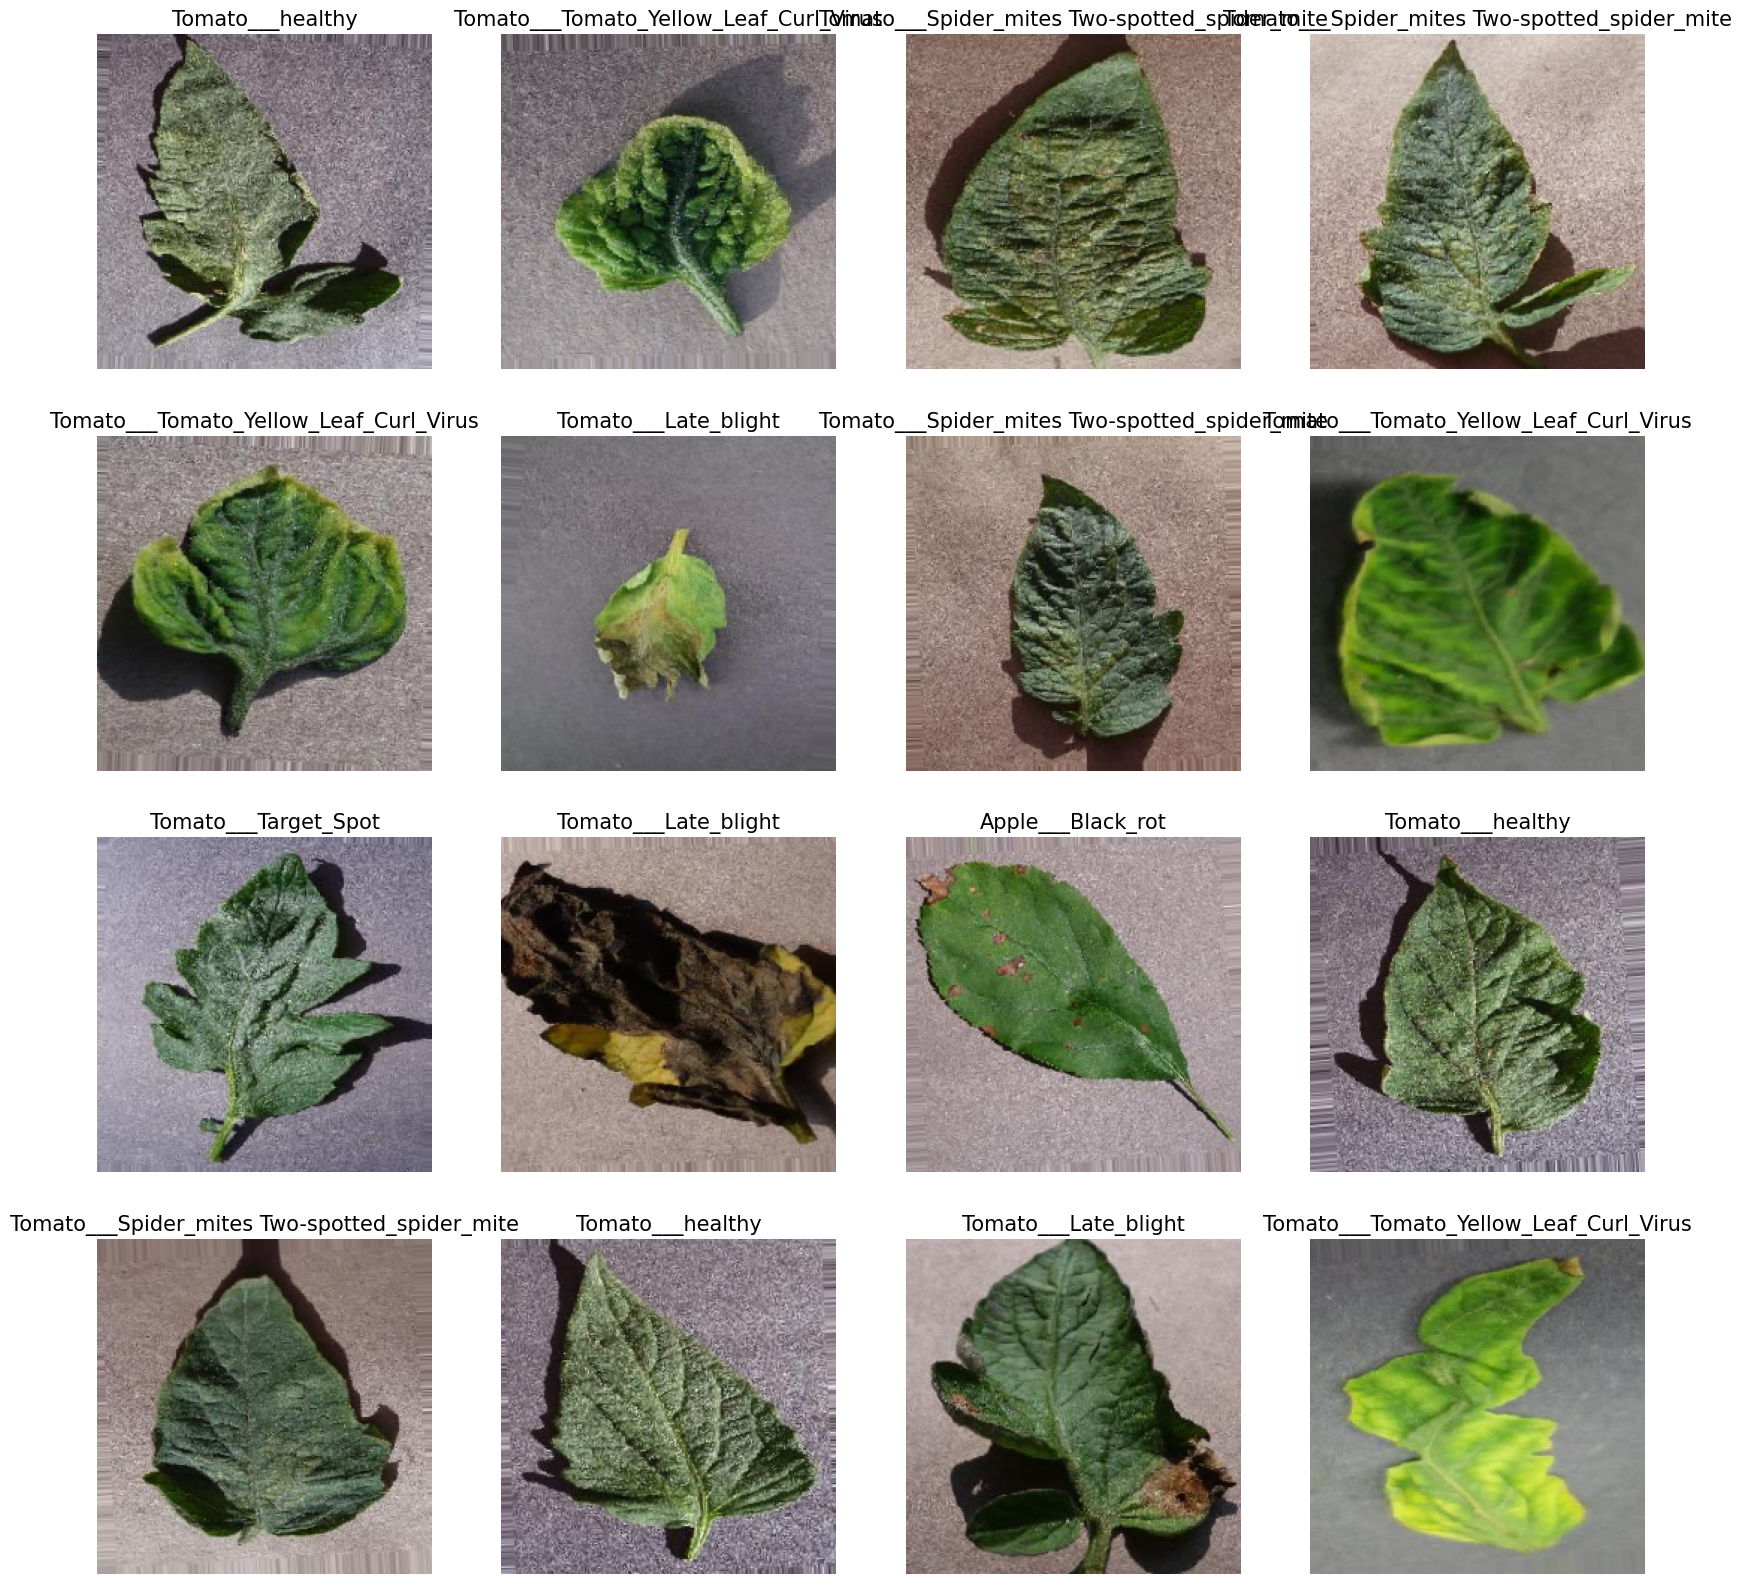

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):

    plt.subplot(4, 4, i + 1)
    image = images[i] / 255.0      # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 15)
    plt.axis('off')

plt.show()

In [ ]:
model = tf.keras.models.load_model("MobileNetV3_PlantVillage_new.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 178 variables whereas the saved optimizer has 354 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


257/257 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step


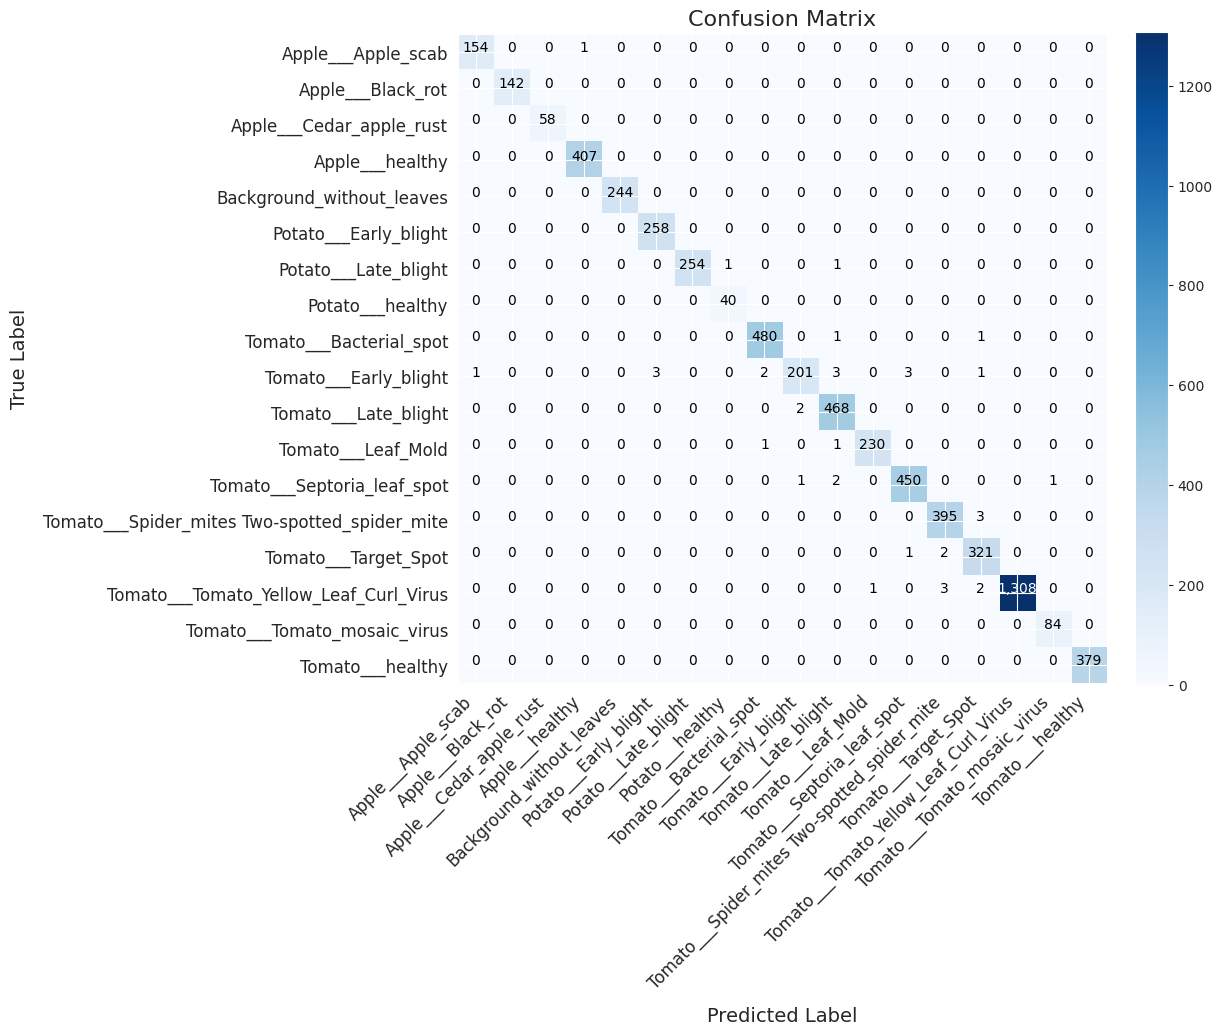

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(12, 12))  # Increase figure size
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(fraction=0.046, pad=0.04)  # Adjust colorbar size

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, ha='right')
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:,}",  # Format numbers with commas
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10)

    plt.tight_layout()
    plt.ylabel('True Label', fontsize=14, labelpad=10)
    plt.xlabel('Predicted Label', fontsize=14, labelpad=10)
    plt.show()

# Generate confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
classes = list(g_dict.keys())

# Plot confusion matrix
plot_confusion_matrix(cm, classes)

In [ ]:
print(classification_report(test_gen.classes, y_pred, target_names=classes, digits=5))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab    0.99355   0.99355   0.99355       155
                            Apple___Black_rot    1.00000   1.00000   1.00000       142
                     Apple___Cedar_apple_rust    1.00000   1.00000   1.00000        58
                              Apple___healthy    0.99755   1.00000   0.99877       407
                    Background_without_leaves    1.00000   1.00000   1.00000       244
                        Potato___Early_blight    0.98851   1.00000   0.99422       258
                         Potato___Late_blight    1.00000   0.99219   0.99608       256
                             Potato___healthy    0.97561   1.00000   0.98765        40
                      Tomato___Bacterial_spot    0.99379   0.99585   0.99482       482
                        Tomato___Early_blight    0.98529   0.93925   0.96172       214
                         Tomato___Late_bli

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# True labels and predicted labels
y_true = test_gen.classes  # True labels from test generator
y_pred = np.argmax(model.predict(test_gen), axis=1)  # Predicted labels from the model

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Extract values from the confusion matrix
TN = cm[0, 0]  # True Negatives
TP = cm[1, 1]  # True Positives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision
precision = precision_score(y_true, y_pred, average='weighted')

# Recall
recall = recall_score(y_true, y_pred, average='weighted')

# F1-Score
f1 = f1_score(y_true, y_pred, average='weighted')

# Specificity (True Negative Rate)
specificity = TN / (TN + FP)

# Negative Predictive Value (NPV)
npv = TN / (TN + FN)

# Display results
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-Score: {f1:.6f}")
print(f"Specificity: {specificity:.6f}")
print(f"Negative Predictive Value (NPV): {npv:.6f}")


257/257 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step
Accuracy: 0.993571
Precision: 0.993595
Recall: 0.993571
F1-Score: 0.993552
Specificity: 1.000000
Negative Predictive Value (NPV): 1.000000
